In [26]:
import os
import mlflow.pyfunc
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.sql.functions import col, sum, when, trim, lit
import mlflow.tracking
import pandas as pd
import numpy as np

# Importações para a matriz de confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


Carregando o modelo

In [27]:

# --- Configuração do Spark Session ---
try:
    spark = SparkSession.builder \
        .appName("FairnessMonitoringSparkSession") \
        .config("spark.local.dir", os.path.join(os.getcwd(), "spark_fairness_tmp")) \
        .config("spark.sql.warehouse.dir", os.path.join(os.getcwd(), "spark-warehouse-fairness")) \
        .getOrCreate()
except Exception:
    spark = SparkSession.builder.getOrCreate()


# --- Função para carregar o Modelo MLflow ---
def load_mlflow_churn_model_for_fairness():
    try:
        mlflow_db_path = "C:/MONICA/Estudos/mlf_data/mlflow.db" 
        tracking_uri = f"sqlite:///{mlflow_db_path}" 
        mlflow.set_tracking_uri(tracking_uri)
        
        client = mlflow.tracking.MlflowClient()
        experiment = client.get_experiment_by_name("churn_prediction") 
        
        if experiment:
            runs = client.search_runs(
                experiment_ids=[experiment.experiment_id],
                order_by=["start_time DESC"],
                max_results=1
            )
            if runs:
                latest_run = runs[0]
                model_uri = f"runs:/{latest_run.info.run_id}/churn_model" 
                return mlflow.pyfunc.load_model(model_uri)
        return None
    except Exception:
        return None

# --- Carregar o Modelo ---
model_mlflow = load_mlflow_churn_model_for_fairness()



2025/07/14 14:27:32 INFO mlflow.spark: File 'C:\Users\mosme\AppData\Local\Temp\tmp6sux9z35\churn_model\sparkml' is already on DFS, copy is not necessary.


Testes de monitoramento

Modelo MLflow carregado com sucesso para monitoramento de fairness.
Dataset '../dataset/churn-bigml-20.csv' carregado com sucesso no Spark DataFrame.

Verificando e tratando valores ausentes no Spark DataFrame (abordagem robusta)...
Transformações de limpeza e tipagem aplicadas e avaliadas.
Valores ausentes tratados no Spark DataFrame. Verificando novamente:
+-----+--------------+---------+-----+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|State|Account length|Area code|Phone|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl 

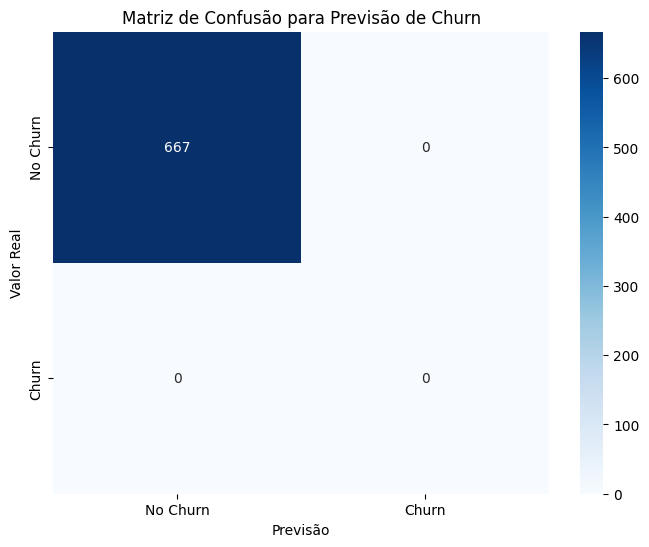


Análise de Fairness por 'International plan':
International plan  predicted_churn
No                  No                 1.0
Yes                 No                 1.0
Name: proportion, dtype: float64


In [ ]:
if model_mlflow:
    print("Modelo MLflow carregado com sucesso para monitoramento de fairness.")
    
    csv_file_path = "../dataset/churn-bigml-20.csv"
    
    data_schema = StructType([
        StructField("State", StringType(), True),
        StructField("Account length", StringType(), True), 
        StructField("Area code", StringType(), True), 
        StructField("Phone", StringType(), True),
        StructField("International plan", StringType(), True),
        StructField("Voice mail plan", StringType(), True),
        StructField("Number vmail messages", StringType(), True), 
        StructField("Total day minutes", StringType(), True), 
        StructField("Total day calls", StringType(), True), 
        StructField("Total day charge", StringType(), True), 
        StructField("Total eve minutes", StringType(), True), 
        StructField("Total eve calls", StringType(), True), 
        StructField("Total eve charge", StringType(), True), 
        StructField("Total night minutes", StringType(), True), 
        StructField("Total night calls", StringType(), True), 
        StructField("Total night charge", StringType(), True), 
        StructField("Total intl minutes", StringType(), True), 
        StructField("Total intl calls", StringType(), True), 
        StructField("Total intl charge", StringType(), True), 
        StructField("Customer service calls", StringType(), True), 
        StructField("Churn", StringType(), True) 
    ])

    try:
        df_spark = spark.read \
            .option("header", "true") \
            .schema(data_schema) \
            .csv(csv_file_path)
        print(f"Dataset '{csv_file_path}' carregado com sucesso no Spark DataFrame.")

        print("\nVerificando e tratando valores ausentes no Spark DataFrame (abordagem robusta)...")

        original_numerical_cols = [
            "Account length", "Area code", "Number vmail messages", "Total day minutes", 
            "Total day calls", "Total day charge", "Total eve minutes", "Total eve calls", 
            "Total eve charge", "Total night minutes", "Total night calls", 
            "Total night charge", "Total intl minutes", "Total intl calls", 
            "Total intl charge", "Customer service calls"
        ]
        
        original_categorical_cols = ["State", "International plan", "Voice mail plan", "Churn"]

        for col_name in original_numerical_cols:
            df_spark = df_spark.withColumn(
                col_name,
                when(trim(col(col_name)) == "", lit(None)) 
                .when(trim(col(col_name)).rlike("^[a-zA-Z]+$"), lit(None)) 
                .otherwise(col(col_name)) 
            )
            df_spark = df_spark.withColumn(col_name, col(col_name).cast(DoubleType()))

        df_spark = df_spark.fillna(0.0, subset=original_numerical_cols)

        for col_name in original_categorical_cols:
            if col_name in ['International plan', 'Voice mail plan']:
                df_spark = df_spark.withColumn(
                    col_name,
                    when(trim(col(col_name)) == "", "No") 
                    .when(col(col_name).isNull(), "No") 
                    .otherwise(col(col_name))
                )
            elif col_name == 'Churn':
                 df_spark = df_spark.withColumn(
                    col_name,
                    when(trim(col(col_name)) == "", "No") 
                    .when(col(col_name).isNull(), "No") 
                    .otherwise(col(col_name))
                )
            else: 
                df_spark = df_spark.withColumn(
                    col_name,
                    when(trim(col(col_name)) == "", "Unknown") 
                    .when(col(col_name).isNull(), "Unknown") 
                    .otherwise(col(col_name))
                )
        
        _ = df_spark.count() 
        print("Transformações de limpeza e tipagem aplicadas e avaliadas.")

        print("Valores ausentes tratados no Spark DataFrame. Verificando novamente:")
        df_spark.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_spark.columns]).show()

        
        features_for_prediction = [
            "Account length",
            "International plan",
            "Number vmail messages",
            "Total day minutes",
            "Total day calls",
            "Total eve minutes",
            "Total eve calls",
            "Total night minutes",
            "Total night calls",
            "Total intl minutes",
            "Total intl calls",
            "Customer service calls"
        ]

        columns_for_analysis = features_for_prediction + ["Churn", "State"] 
        
        df_selected_spark = df_spark.select(columns_for_analysis)
        df_pandas = df_selected_spark.toPandas() 
        
        print("AAAAA")

        X_predict = df_pandas[features_for_prediction]

        print("BBBB")
        
        predictions = model_mlflow.predict(X_predict)

        print("CCCC")
        
        df_pandas['predicted_churn_label'] = predictions
        df_pandas['predicted_churn'] = df_pandas['predicted_churn_label'].apply(lambda x: 'Yes' if x == 1.0 else 'No')
        
        print("Previsões realizadas no dataset.")
        print("Amostra do DataFrame com previsões:")
        print(df_pandas[['International plan', 'State', 'Churn', 'predicted_churn']].head())

        # --- Lógica para Gráfico de Confusão ---
        print("\nGerando Matriz de Confusão...")
        
        y_true = df_pandas['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
        y_pred = df_pandas['predicted_churn_label']

        cm = confusion_matrix(y_true, y_pred, labels=[0, 1]) 

        labels = ['No Churn', 'Churn']

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Previsão')
        plt.ylabel('Valor Real')
        plt.title('Matriz de Confusão para Previsão de Churn')
        plt.show()

        print("\nAnálise de Fairness por 'International plan':")
        fairness_by_plan = df_pandas.groupby('International plan')['predicted_churn'].value_counts(normalize=True)
        print(fairness_by_plan)
        

    except Exception as e:
        print(f"Erro ao carregar ou processar o dataset ou gerar gráfico: {e}")
else:
    print("Não foi possível carregar o modelo. O monitoramento de fairness não pode prosseguir.")